# 1. Describe the data
- The monthly number of airline passengers from the early years of air travel.
- It has 144 observations.
- There are 2 variables:
    - pass: number of passenger
    - year: time point in a format(Jan=0.083, Feb=0.167, Mar=0.250, Apr=0.333, May=0.417, Jun=0.500, Jul=0.583, Aug=0.667, Sep=0.750, Oct=0.833, Nov=0.917, Dec=1.000)

# 2. Load packages and data

In [1]:
import pandas as pd, numpy as np, scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import faraway.utils

In [11]:
import faraway.datasets.air
air = faraway.datasets.air.load()
air = air.rename(columns={'pass': 'passengers'}) # because pass is a key word
air.head()

,passengers,year
0,112,49.083333
1,118,49.166667
2,132,49.250000
3,129,49.333333
4,121,49.416667


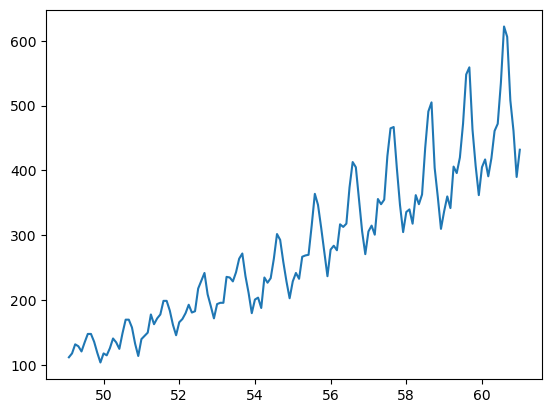

In [12]:
plt.plot(air['year'], air['passengers']);

# 3. Linear regression

In [13]:
# Create elements for running regression
X = pd.DataFrame({'Intercept':1, 'year':air['year']})
y = np.log(air['passengers'])

In [14]:
# Run regression
lmod = sm.OLS(y,X).fit()

In [15]:
lmod.sumary()

           coefs stderr tvalues pvalues
Intercept -1.095  0.184   -5.93  0.0000
year       0.121  0.003   36.05  0.0000

n=144 p=2 Residual SD=0.139 R-squared=0.90


In [16]:
lmod2 = smf.ols(formula='np.log(passengers) ~ year', data=air).fit()

In [17]:
lmod2.sumary()

           coefs stderr tvalues pvalues
Intercept -1.095  0.184   -5.93  0.0000
year       0.121  0.003   36.05  0.0000

n=144 p=2 Residual SD=0.139 R-squared=0.90


- Both statsmodels.api and statsmodels.formula.api come from the same package, statsmodels. They provide different interfaces for fitting statistical models.
- statsmodels.api:
    - Provides a more traditional interface for statistical modeling.
    - We need to manually create design matrices (e.g., using pandas DataFrames) and pass them to the model.
- statsmodels.formula.api:
    - Provides a formula-based interface similar to R's formula syntax.
    - Allows you to specify models using a formula string, which can include transformations and interactions.
    - Automatically handles the creation of design matrices.

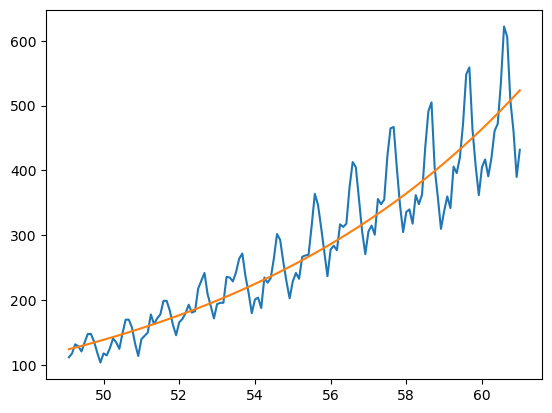

In [18]:
plt.plot(air['year'], air['passengers'])
plt.plot(air['year'],np.exp(lmod.predict()));

## 3.1 Autoregression
$y_t = β_0 + β_1 y_{t-1} + β_{12} y_{t-12} + β_{13} y_{t-13} + \epsilon_t$

In [39]:
# Create columns of lags
air['lag1'] = np.log(air['passengers']).shift(1)
air['lag12'] = np.log(air['passengers']).shift(12)
air['lag13'] = np.log(air['passengers']).shift(13)
airlag = air.dropna(); airlag

,passengers,year,lag1,lag12,lag13
13,126,50.166667,4.744932,4.770685,4.718499
14,141,50.250000,4.836282,4.882802,4.770685
15,135,50.333333,4.948760,4.859812,4.882802
16,125,50.416667,4.905275,4.795791,4.859812
17,149,50.500000,4.828314,4.905275,4.795791
...,...,...,...,...,...
139,606,60.666667,6.432940,6.326149,6.306275
140,508,60.750000,6.406880,6.137727,6.326149
141,461,60.833333,6.230481,6.008813,6.137727
142,390,60.916667,6.133398,5.891644,6.008813


In [40]:
# Create elements for running regression
X = airlag.loc[:,('lag1', 'lag12', 'lag13')]
X.insert(0, 'Intercept', 1)
y = np.log(airlag['passengers'])

In [41]:
# Run regression
lmod = sm.OLS(y,X).fit()
lmod.sumary()

           coefs stderr tvalues pvalues
Intercept  0.138  0.054    2.58  0.0109
lag1       0.692  0.062   11.19  0.0000
lag12      0.922  0.035   26.53  0.0000
lag13     -0.632  0.068   -9.34  0.0000

n=131 p=4 Residual SD=0.042 R-squared=0.99


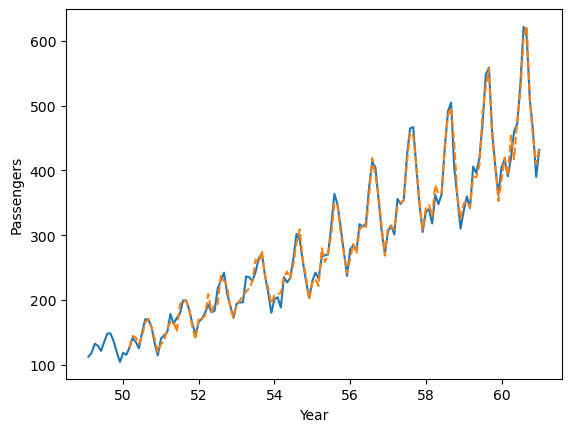

In [43]:
plt.plot(air['year'], air['passengers'])
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.plot(airlag['year'],np.exp(lmod.predict()),linestyle='dashed');

# 4. Prediction
Predicting the number of passenger of the next month

In [47]:
# Get the values of lags
z = np.log(air['passengers'].iloc[[-1,-12,-13]]).values; z

array([6.06842559, 6.03308622, 6.00388707])

In [48]:
# Create element for running prediction
x0 = pd.DataFrame([{"const":1,"lag1": z[0], "lag12": z[1], "lag13": z[2]}])

In [49]:
# Run prediction
lmod.get_prediction(x0).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,6.103985,0.006375,6.09137,6.116601,6.020619,6.187351
